In [3]:
from __future__ import print_function
import os
import re
import json
import numpy as np
import operator
from matplotlib import pyplot as plt

PATH = '../storecam_data'

frames = {}
for filename in os.listdir(PATH):
    with open(PATH + '/' + filename, 'r') as data_file:
        reg = re.search('storecam_(\d+?)_keypoints.json', filename)
        if reg:
            n_frame = reg.group(1)
            frames[int(n_frame)] = json.load(data_file)


Frames es un arreglo, para cada frame tiene diccionario donde en 'people' estan las poses.


In [4]:
len(frames.values()[100]['people'][0]['pose_keypoints_2d'])

54

In [5]:
# Pasa las poses de OpenPose a la forma [[x,y]]
def pose2body(pose):
    return np.array([[x,y] for x,y in zip(pose['pose_keypoints_2d'][::3],pose['pose_keypoints_2d'][1::3]) 
                      if x != 0 and y != 0])

# Pasa la lista de poses de OpenPose a una lista de cajas que contienen cada cuerpo de la forma [x1,y1,x2,y2]
def bodys2dets(poses): 
    bodies = [pose2body(pose) for pose in poses]
    boxes = []
    for body in bodies:
        box = [ int(min(body,key = lambda x: x[0])[0]),int(min(body,key = lambda x: x[1])[1]),
               int(max(body,key = lambda x: x[0])[0]),int(max(body,key = lambda x: x[1])[1])]
        boxes.append(box)
    return np.array(boxes)

# Kalman Filter

In [6]:
import tracker
reload(tracker)
from tracker import Tracker

import cv2

cap = cv2.VideoCapture("../output.avi")

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 30.0, (1280,720))

tracker = Tracker()

# Colores para las cajas
colours = np.random.rand(32, 3) * 255

frame_i = 0
# Arreglo de personas: persons[id_persona][frame]= [pose points]
persons = {}
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        poses = frames[frame_i]['people']
        # Dets son las cajas de las personas en ese frame
        dets = bodys2dets(poses)
        trackers = tracker.update(dets)
        
        # Deja global el frame_i que no tenga personas
        if len(trackers) == 0:
            empty_frame = frame_i
        
        for x1,y1,x2,y2,idPersona in trackers:
            # Agrego a arreglo de personas
            if idPersona not in persons:
                persons[idPersona] = {}
            # Asigna puntos del cuerpo a esa persona en ese frame
            # Deberia ser la pose entera!!!!
            persons[idPersona][frame_i] = [x1,y1,x2,y2,idPersona]           
            #Dibujo en video
            # Caja
            cv2.rectangle(frame,(int(x1),int(y1)),(int(x2),int(y2)),colours[int(idPersona) % 32, :],4)
            # Fondo de cartel
            cv2.rectangle(frame,(int(x1),int(y1)),(int(x1)+100,int(y1)-20),(255,255,255),-1)
            # Cartel
            cv2.putText(frame, "id = " + str(int(idPersona)),(int(x1),int(y1)),cv2.FONT_HERSHEY_COMPLEX_SMALL,0.8,(0,0,0),2,cv2.LINE_AA)
          
        out.write(frame)

        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
        frame_i += 1
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

kalman_tracker.py:97: RuntimeWarning: divide by zero encountered in divide
  r = w/float(h)
kalman_tracker.py:105: RuntimeWarning: invalid value encountered in multiply
  w = np.sqrt(x[2]*x[3])
kalman_tracker.py:106: RuntimeWarning: invalid value encountered in divide
  h = x[2]/w


Filtro las personas, saco los outliners que estuvieron pocos frames, probablemente errores de detección

In [7]:
persons = {pid: frames for pid, frames in persons.iteritems() if len(frames) > 20}
print("{} personas detectadas".format(len(persons)))

23 personas detectadas


# Time series

In [8]:
# Calcula el punto medio de una caja
midpoint = lambda d: (np.mean([d[0],d[2]]), np.mean([d[1],d[3]]))

In [9]:
for person_id in persons.iterkeys():
    print(person_id, end= " ")

1.0 2.0 3.0 4.0 5.0 129 10 158 39 46 30 56 59 53 193 66 195 68 197 199 74 87 222 

Grafica las trayectorias de todas las personas vistas, x=f(t), y=f(t)

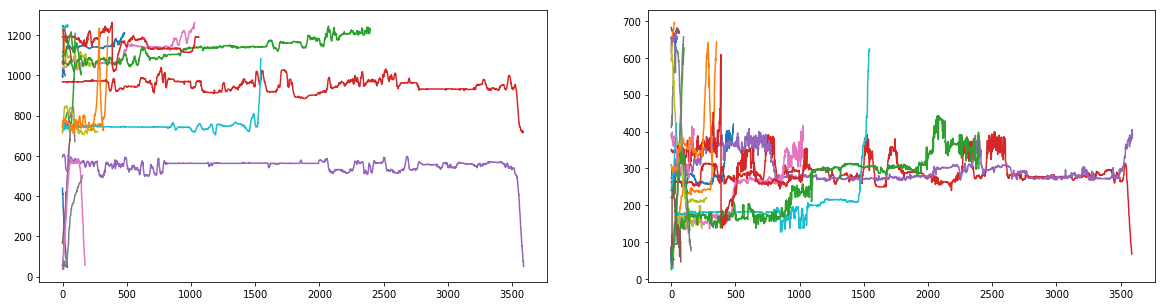

In [10]:
fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(1, 2, 1)
for pid, trace in persons.iteritems():
    trace_x = [midpoint(box)[0] for box in trace.itervalues()]
    plt.plot(trace_x)
    

ax = fig.add_subplot(1, 2, 2)
for pid, trace in persons.iteritems():
    trace_y = [midpoint(box)[1] for box in trace.itervalues()]
    plt.plot(trace_y)


Grafica las trayectorias de dos personas por ID, resampleadas a 100 puntos.

In [11]:
PERSONA_UNO_ID = 2
PERSONA_DOS_ID = 46

In [12]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.clustering import TimeSeriesKMeans

# Calcula el punto medio de una caja
midpoint = lambda d: (np.mean([d[0],d[2]]), np.mean([d[1],d[3]]))

# Creo los arreglos para el uso de tslearn
# En time_series queda la secuencia de puntos medios para las personas
time_series = [[midpoint(d) for d in frames.values()]
                   for pid, frames in persons.iteritems() if pid == PERSONA_UNO_ID or pid == PERSONA_DOS_ID]
# En Y las ids de cada miembro de larreglo en time_series
Y = [pid for pid, frames in persons.items()]


SIZE_SERIE = 100
X = TimeSeriesResampler(sz=SIZE_SERIE).fit_transform(time_series)
print(X.shape)
print("{} personas, {} frames con {} puntos cada uno".format(X.shape[0],X.shape[1],X.shape[2]))



fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(1, 2, 1)
for i in range(X.shape[0]):
    plt.plot(X[i,:,0])

ax = fig.add_subplot(1, 2, 2)
for i in range(X.shape[0]):
    plt.plot(X[i,:,1])

(2, 100, 2)
2 personas, 100 frames con 2 puntos cada uno


# Usando grid

Funciones de convertir a grid

In [13]:
IMG_WIDTH = 1280
IMG_HEIGHT = 720
GRID_SIZE = (128,72)



# Calcula el punto medio de una caja
midpoint = lambda d: (np.mean([d[0],d[2]]), np.mean([d[1],d[3]]))
midpoint_trajectory = lambda person_id: [midpoint(pose_box) for pose_box in persons[person_id].values() ]

def pos_to_grid(x,y):
    grid_x = x  / GRID_SIZE[0]
    grid_y = y  / GRID_SIZE[1]
    grid_char = str((int(grid_y) * int(IMG_WIDTH / GRID_SIZE[0])) + int(grid_x) )
    return grid_char
    
def convert_to_string(trace):
    grid_trace = {}
    for frame, box in trace.iteritems():
        mid = midpoint(box)
        grid_trace[frame] = pos_to_grid(mid[0],mid[1])
    return grid_trace 

def delete_waits(strace):
    nowait_strace = []
    last = None
    for pos in strace:
        if last is None or pos != nowait_strace[-1]:
            nowait_strace.append(pos)
        last = pos
    return nowait_strace 

print("PERSONA 2")
p2_strace = delete_waits(convert_to_string(persons[2.0]).values())
print(p2_strace)

print("PERSONA 3")
p3_strace = delete_waits(convert_to_string(persons[3.0]).values())
print(p3_strace)

PERSONA 2
['5', '15', '25', '35', '36', '35', '36', '46', '56', '66', '77', '87', '88', '89']
PERSONA 3
['35', '36', '46', '45', '55', '56', '66', '76', '77', '87', '88', '89']


Busca un frame vacio y muestra la grilla

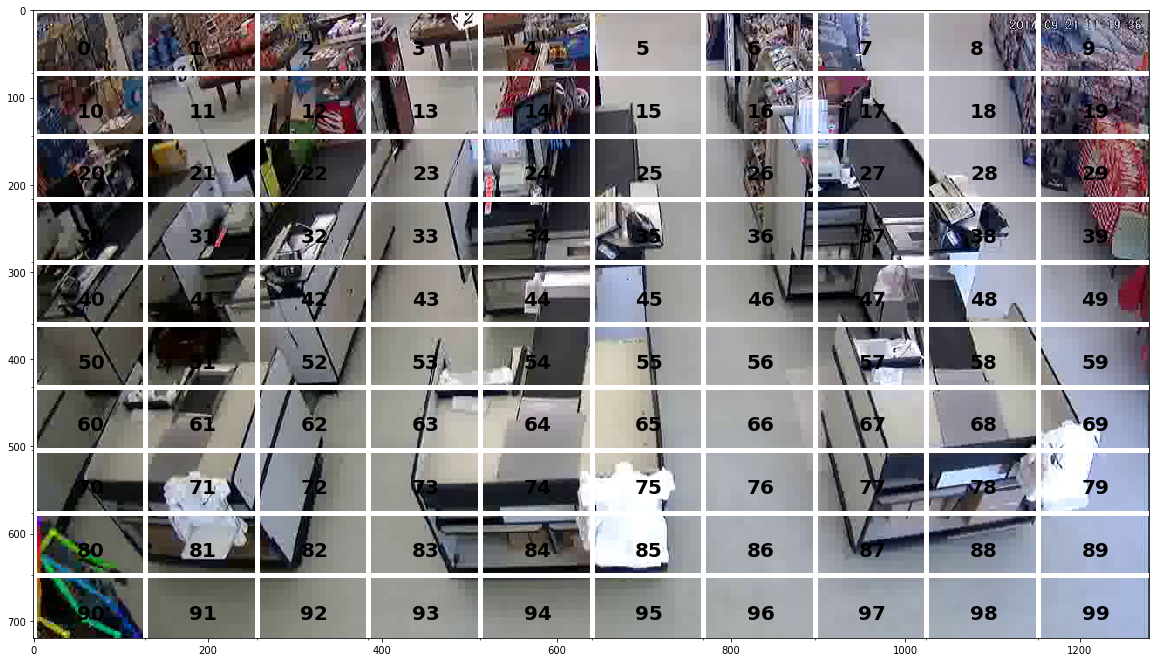

In [14]:
def make_empty_frame():
    cap = cv2.VideoCapture("../output.avi")
    # empty_frame debe estar global
    cap.set(1, empty_frame)
    res, frame = cap.read()
    fig2 = plt.figure(figsize = (20,20))
    ax3 = fig2.add_subplot(111)
    ax3.imshow(frame[:,:,::-1])
    ax3.set_xticks(np.arange(0, IMG_WIDTH, GRID_SIZE[0]), minor=True);
    ax3.set_yticks(np.arange(0, IMG_HEIGHT, GRID_SIZE[1]), minor=True);
    ax3.grid(which='minor', color='w', linestyle='-', linewidth=5)
    # Muestra que grilla es cada una
    for x in range(50,IMG_WIDTH,GRID_SIZE[0]):
        for y in range(50,IMG_HEIGHT,GRID_SIZE[1]):
            grid = pos_to_grid(x,y)
            plt.text(x,y, "{}".format(grid), size = 20, weight = 'bold')

    
make_empty_frame()


# Busqueda de similares por DTW

In [15]:
PERSONA = 2.0
make_empty_frame()
trajectory = midpoint_trajectory(2.0)
plt.plot([p[0] for p in trajectory] , [p[1] for p in trajectory], color = 'red', linewidth=5)
p2_strace = delete_waits(convert_to_string(persons[2.0]).values())
print(p2_strace)


['5', '15', '25', '35', '36', '35', '36', '46', '56', '66', '77', '87', '88', '89']


Calculo la distancia con cada otra persona

In [16]:
query = ['']
from dtw import dtw
#dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))

def distancia_midpoints(mid1, mid2):
    return np.linalg.norm(np.array(mid1)-np.array(mid2))

    
print(midpoint_trajectory(2.0)[0])
distancia_midpoints(midpoint_trajectory(2.0)[0],midpoint_trajectory(2.0)[200])

dist, cost, acc, path = dtw(midpoint_trajectory(2.0), midpoint_trajectory(2.0), dist=distancia_midpoints)

distancias = {}
for person_id in persons.keys():
    dist, cost, acc, path = dtw(midpoint_trajectory(person_id), midpoint_trajectory(2.0), dist=distancia_midpoints)
    distancias[person_id] = dist

(757.5, 62.0)


Muestor distancias

0.0
11.02126698840282
21.484938917255175
25.24709790345319
65.17617446535762
72.50071732569279


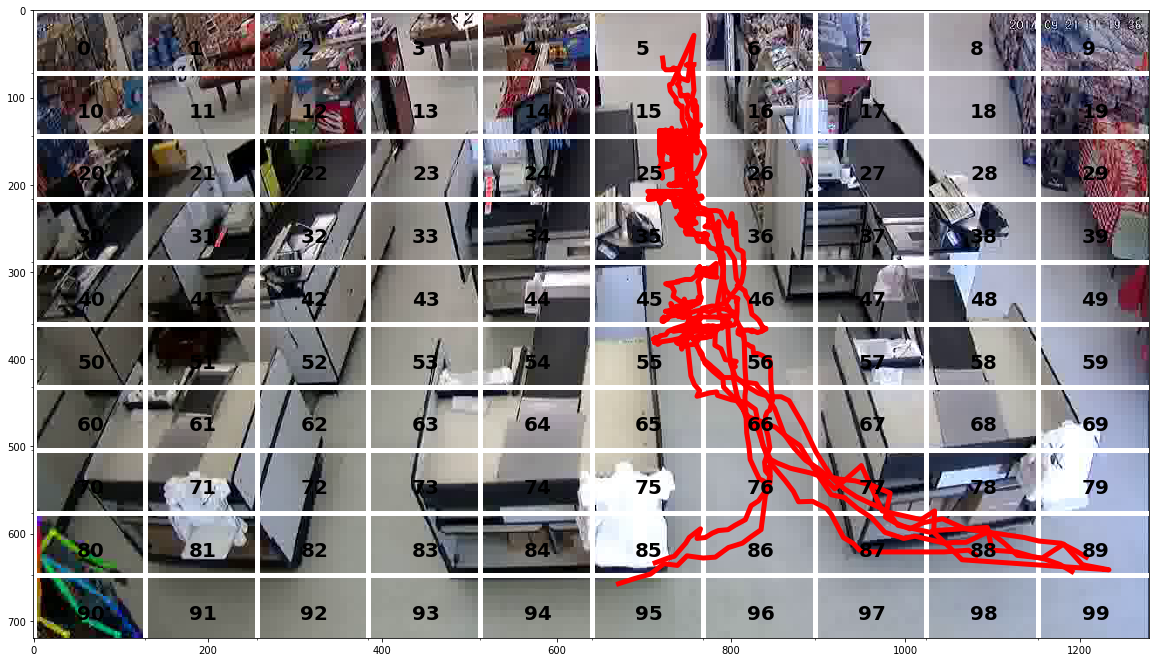

In [17]:
import operator


make_empty_frame()
sorted_x = sorted(distancias.items(), key=operator.itemgetter(1))
for person_id, distance in sorted_x[:6]:
    print(distance)
    trajectory = midpoint_trajectory(person_id)
    plt.plot([p[0] for p in trajectory] , [p[1] for p in trajectory], color = 'red', linewidth=5)

# Clustering

In [24]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.clustering import TimeSeriesKMeans

# Calcula el punto medio de una caja
midpoint = lambda d: (np.mean([d[0],d[2]]), np.mean([d[1],d[3]]))

# Creo los arreglos para el uso de tslearn
# En time_series queda la secuencia de puntos medios para las personas
time_series = [[midpoint(d) for d in frames.values()]
                   for pid, frames in persons.iteritems()]
# En Y las ids de cada miembro de larreglo en time_series
Y = [pid for pid, frames in persons.items()]


SIZE_SERIE = 100
X = TimeSeriesResampler(sz=SIZE_SERIE).fit_transform(time_series)
print(X.shape)
print("{} personas, {} frames con {} puntos cada uno".format(X.shape[0],X.shape[1],X.shape[2]))

seed = 0
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed, metric = "dtw")
y_pred = km.fit_predict(X)

(23, 100, 2)
23 personas, 100 frames con 2 puntos cada uno
3859898.684 --> 2271173.226 --> 2271173.226 --> 


Crea un video output_cluster.avi mostrando el cluster asignado a cada persona

In [23]:

cap = cv2.VideoCapture("../output.avi")

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_cluster.avi',fourcc, 30.0, (1280,720))

tracker = Tracker()

# Colores para las cajas
colours = np.random.rand(32, 3) * 255

frame_i = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        for pid, frames in persons.items():
            if frame_i in frames:
                x1,y1,x2,y2, idPersona = frames[frame_i]
                #Dibujo en video
                cv2.rectangle(frame,(int(x1),int(y1)),(int(x2),int(y2)),colours[int(idPersona) % 32, :],4)
                cv2.rectangle(frame,(int(x1),int(y1)),(int(x1)+100,int(y1)-20),(255,255,255),-1)
                cv2.putText(frame, "pid = {}, cluster = {} ".format(idPersona,y_pred[Y.index(pid)]),
                            (int(x1),int(y1)),cv2.FONT_HERSHEY_COMPLEX_SMALL,0.8,(0,0,0),2,cv2.LINE_AA)
            
        out.write(frame)
        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
        frame_i += 1
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

Muestra las trayectorias de las personas en cada cluster en una unica imagen del video

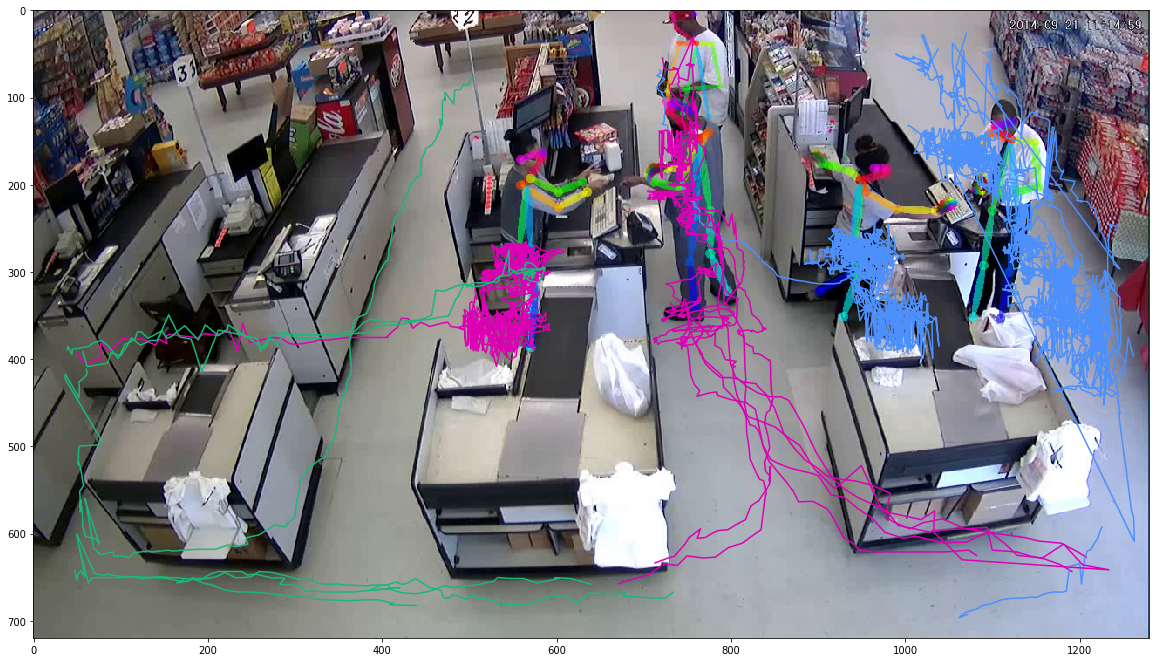

In [26]:
from matplotlib import pyplot as plt
from scipy.interpolate import splprep, splev
import pylab

# Agarro un frame cualquiera y lo muestro
FRAME = 1
cap = cv2.VideoCapture("../output.avi")
cap.set(1, FRAME)
res, frame = cap.read()

fig2 = plt.figure(figsize = (20,20))
ax3 = fig2.add_subplot(111)
ax3.imshow(frame[:,:,::-1])

colours = np.array(np.random.rand(32, 3) * 255)

# Dibujo para cada persona en cada frame su punto medio con el color del cluster que se le asignó
for pid, frames in persons.items():
    path = np.array([midpoint(box) for box in frames.values()])
    cluster = y_pred[Y.index(pid)]
    Y2 = path
    plt.plot([p[0] for p in path], [p[1] for p in path], color = colours[cluster%32,:]/255)